# Linear Regression

## Mod√®le explicatif

On a observ√© deux ensembles de var X et Y sur n individus tel que $y = f(x) + \epsilon$

On suppose que $f$ est une fonction lineaire √©gale √†: $f: x \mapsto ax + b$

### Diff√©rences avec l'ACP

Dans une ACP, les variables n'ont pas de relation entre elles.
Ici, y d√©pend de x.

### Crit√®re des moindres carr√©es

Le r√©sidu ($e_i = y_i - \hat{y}_i$) correspond √† ce qui n'est pas expliqu√© par le mod√®le. On cherche √† le minimiser.

On va chercher √† a et b en minimisant le carr√© des r√©sidus, c'est-√†-dire:

$
\min \sum_i e^2_i = \min \sum_i (y_i - \hat{y}_i)^2
$

La solution optimale donne:

$
b = \frac {\sum (x_i - \overline{x})(y_i - \overline{y})}{\sum (x_i - \overline{x})^2}
b = \frac {cov(x,y)}{var(x)}
$

$
a = \overline{y} - b \overline{x}
$

In [1]:
# Iris dataset
!ls iris.data || wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

iris.data


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn import linear_model
from scipy.stats import norm
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv("iris.data", header=None, names=["sepal length", "sepal width", "petal length", "petal width", "class"])
df = df[df["class"] == "Iris-setosa"]
df.describe()

sepal length  sepal width  petal length  petal width
count      50.00000    50.000000     50.000000     50.00000
mean        5.00600     3.418000      1.464000      0.24400
std         0.35249     0.381024      0.173511      0.10721
min         4.30000     2.300000      1.000000      0.10000
25%         4.80000     3.125000      1.400000      0.20000
50%         5.00000     3.400000      1.500000      0.20000
75%         5.20000     3.675000      1.575000      0.30000
max         5.80000     4.400000      1.900000      0.60000

Text(0, 0.5, 'sepal width')

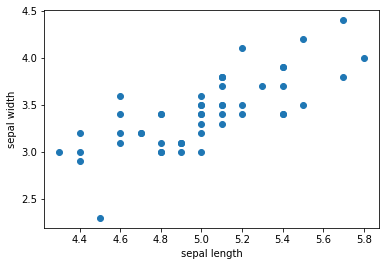

In [4]:
X = df["sepal length"]
y = df["sepal width"]
plt.scatter(X, y)
plt.xlabel("sepal length")
plt.ylabel("sepal width")

In [5]:
X_ = np.average(X)
y_ = np.average(y)
cov_Xy = np.sum((X - X_) * (y - y_))
var_x = np.sum((X - X_) ** 2)
a = cov_Xy / var_x
b = y_ - a * X_

reg = linear_model.LinearRegression()
reg.fit(X.to_numpy().reshape(1, -1).T, y)

res = sm.OLS(y, sm.add_constant(X, prepend=False)).fit()

pd.DataFrame([
    ["manually", a, b],
    ["sk-learn", reg.coef_[0], reg.intercept_],
    ["statsmodels", res.params[0], res.params[1]]],
    columns=["Method", "Coeff", "Intercept"])

Method     Coeff  Intercept
0     manually  0.807234  -0.623012
1     sk-learn  0.807234  -0.623012
2  statsmodels  0.807234  -0.623012

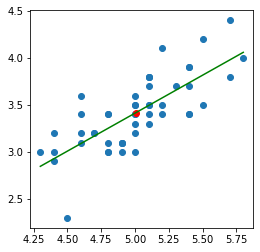

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
ax.plot(X_test, y_test, color="green")
ax.scatter(X_, y_, color="red")

### Propri√©t√©s

 - La droite passe par ($\overline{x}$, $\overline{y}$)
 - $\overline{y} = \hat{\overline{y}}$ (moyenne des y = moyenne des y pr√©dits)
 - $\sum e_i = 0$
 - $\sum e_i x_i = 0$
 
### Qualit√© de l'ajustement lin√©aire

$
\underbrace{\sum (y_i - \overline{y})^2}_{\text{Somme des carr√©s totaux}} = \underbrace{\sum (y_i - \hat{y}_i)^2}_{\text{Somme des carr√©s des r√©sidus (SCR)/information non expliqu√©e}} + \underbrace{\sum (\hat{y}_i - \overline{y})^2}_{\text{Somme des carr√©s (SCE)/information expliqu√©e par le mod√®le, par la droite}}
$

### Coefficient de d√©termination

$
R^2 = \frac{SCE}{SCT} = \frac {\sum (\hat{y}_i)^2 - \overline{y})^2}{\sum (y_i - \overline{y})^2} = b^2 \frac{s^2_x}{s^2_y} = (cor(x, y)) ^2
$

R¬≤ mesure l'ajustement de la droite aux donn√©es. R¬≤ explique la part de variation de y expliqu√©e par la variation de x

## Etude des points influents et des r√©sidus
### Contribution de chaque observation

**Levier** : Contribution d'un point √† la construction de la droite
$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum (x_j - \overline{x})^2}
$

$h_i$ important is $\gt \frac {4}{n}$. Le levier indique une _potentielle_ influence par rapport √† la pente. Pas d'influence => si on retire le point, elle n'impacte pas la droite

Un point abberant (√©loign√© de la droite) mais pas influent (proche de la moyenne) aura un levier faible => influence sur la distance de Cook faible = levier faible * r√©sidu important

 - Influence en g√©n√©ral: **Distance de Cook** pour l'observation i = $D_i = \frac {\hat{y_j} - \hat{y}_{(-i)j}} {2 \hat{\sigma}^2} = \underbrace {\frac{(e_i)^2}{\hat{\sigma}^2}}_{\text{r√©sidu studentis√©, influence / y}} \underbrace {\frac {h_i} {(1-h_i)^2}}_{\text{fonction du levier, influence / x}}$
 - Influence variabilit√©: **Cov Ratio**. Grand si |CovRatio - 1| >3 (P+1)/2
 - Influence pr√©diction: **DFFITS**. Grand si > 2 * sqrt(P+1) / n
 - Influence pente: **DFBETAS_x**. Grand si |DFBETAS| > 2 / sqrt(n)
 - Influence ordonn√©e √† l'origine: **DFBETAS_intercept** 

/home/yvan/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


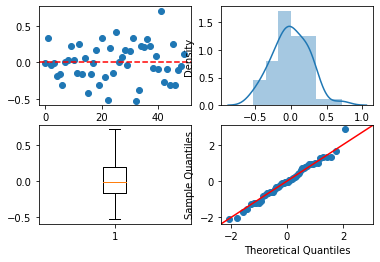

In [7]:
≈∑ = a * X + b
residuals = (≈∑ - y)
fig, ax = plt.subplots(2, 2)
ax[0, 0].scatter(range(len(residuals)), residuals)
ax[0, 0].axhline(y = 0, color = 'r', linestyle = 'dashed')

ax[1, 0].boxplot(residuals)

_ = sns.distplot(residuals, ax=ax[0, 1])

_ = sm.qqplot(residuals, stats.t, fit=True, line="45", ax=ax[1, 1])

Exemples de r√©sidus ne respectant pas les hypoth√®ses

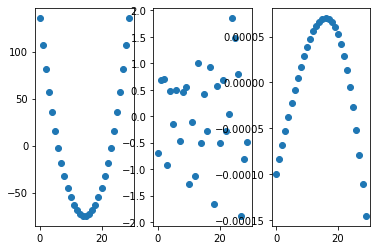

In [8]:
fig, ax = plt.subplots(1, 3)
eX = np.array(range(30))
e = [
    ["Relation non-lin√©aire entre x & y, envisager un mod√®le en x¬≤", eX**2],
    ["H√©t√©rosc√©dasticit√©. Le r√©sidu augmente en fonction de x. Envisager de r√©gresser log Y en x", eX+np.array([np.random.normal(loc=10*x, scale=1) for x in eX])],
    ["Autocorrelation, n√©cessite l'utilisation de s√©ries chronologiques", np.sin(eX/200)]
]

for i, values in enumerate(e):
    text, ey = values
    res_e = sm.OLS(ey, sm.add_constant(eX, prepend=False)).fit()
    ax[i].scatter(eX, res_e.resid)

In [9]:
infl = res.get_influence()
iris_desc = pd.DataFrame(zip(
    infl.resid_std,
    infl.resid_studentized,
    infl.cooks_distance[0],
    infl.hat_matrix_diag,
    infl.cov_ratio,
    infl.dffits[0],
    infl.dfbetas[:, 0],
    infl.dfbetas[:, 1]), columns=[
    "StdDev Residual",
    "Student Residual",
    "Cook distance",
    "Hat Diag H",
    "Cov Ratio",
    "Dffits",
    "Dfbetas Coef",
    "Dfbetas Intercept",
])
iris_desc.head()

StdDev Residual  Student Residual  Cook distance  Hat Diag H  Cov Ratio  \
0         0.253273          0.024164       0.000006    0.021451   1.065844   
1         0.253222         -1.312812       0.019246    0.021846   0.991102   
2         0.251464          0.115378       0.000244    0.035380   1.080661   
3         0.249935          0.038958       0.000037    0.047075   1.094461   
4         0.253460          0.737171       0.005547    0.020006   1.040336   

     Dffits  Dfbetas Coef  Dfbetas Intercept  
0  0.003540      0.000921          -0.000681  
1 -0.197719      0.057468          -0.070485  
2  0.021868     -0.014418           0.015527  
3  0.008568     -0.006498           0.006871  
4  0.104818     -0.001802           0.009085

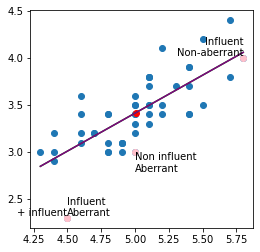

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
y_sm = res.params[0] * X_test + res.params[1]
ax.plot(X_test, y_test, color="green")
ax.plot(X_test, y_sm, color="purple")
ax.scatter(X_, y_, color="red")

points = [
    (41, 'Influent\nAberrant', 'left', 'bottom'),
    (14, 'Influent\nNon-aberrant', 'right', 'bottom'),
    (25, 'Non influent\nAberrant', 'left', 'top'),
    # index_point == 32
    (np.argmax(iris_desc["Cook distance"]), '+ influent', 'right', 'bottom'),
]

for index_point, text, ha, va in points:
    xp, yp = X[index_point], y[index_point]
    ax.scatter(xp, yp, color="pink")
    ax.text(xp, yp, text, ha=ha, va=va)

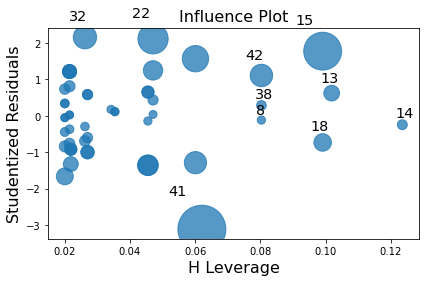

In [11]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

#### Reference

 - https://online.stat.psu.edu/stat462/node/173/
 - https://blogs.sas.com/content/iml/2019/06/19/influence-regression-dffits-cooksd.html
 - https://www.kaggle.com/code/kmaingleung/use-cooks-disatnce-dffits-for-outlier-detection


## Aspects inf√©rentiels

### Mod√®le de regression simple

Soit ($X_i$, $y_i$), un **√©chantillon** de n individus issues de la population d√©crite par:
$
y_i = \underbrace{Y / x_i}_{\text{Loi Y conditionn√© √† x_i (connu)}} = \alpha x_i + \beta + \epsilon_i
$

Œ± et Œ≤ sont des constantes inconnues.

#### Hypoth√®ses

 * $E(epsilon_i)=0$ : √©vite un biais syst√©matique
 * $V(epsilon_i)=\sigma^2$ : hypoth√®se d'homosc√©cadicit√©
 * $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$: hypoth√®se de normalit√© des erreurs => $y_i \sim \mathcal{N}(\alpha x_i + \beta, \sigma^2)$ 
 * $\epsilon_i$ identiques et ind√©pendamment distribu√©s (iid) <=> $\forall i \ne j, cov(\epsilon_i, \epsilon_j) = 0$
 
#### Estimateurs et loi des estimateurs

On va construire deux estimateurs A et B √† partir de l'√©chantillon. La solutions du syst√®me des √©quations normales a et b donne les estimateurs des moindres carr√©s des param√®tres Œ± et Œ≤

Les r√©sidus $\epsilon_i$ suivent une loi normale $\mathcal{N}(0, \sigma^2)$. Les estimateurs A et B des valeurs Œ± et Œ≤ suivent des lois normales.

$
A \sim \mathcal{N}(a, \frac{\sigma^2}{\sum (x_i - \overline{x})^2}) \\
B \sim \mathcal{N}(b, \sigma^2 \left [ \frac{1}{n} + \frac{\overline{x}}{\sum (x_i - \overline{x})^2} \right ])
$

Mais, $\sigma$, la variance des r√©sidus, n'est pas **connu**. Il faut donc l'estimer! L'estimateur sans biais de la variance des erreurs  $\sigma^2$ est: $S_{n-2}^2 = \frac{1}{n-2} \sum (\hat{y}_i - y_i)^2$

$\frac{A - \alpha}{S_{A}}$ et $\frac{B - \beta}{S_{B}}$ suivent des lois de Student avec n-2 degr√©s de libert√© ($T_{n-2}$) 

Avec:
$ 
S_A = S_{n-2} \frac{1}{\sqrt{\sum (x_i - \overline{x})^2}}
\ et\ 
S_B = S_{n-2} \sqrt{\frac{1}{n} + \frac{\overline{x}^2}{\sum (x_i - \overline{x})^2}}
$

In [12]:
from math import sqrt
n = len(residuals)
ùúé_squared = sqrt(sum(residuals**2) / (n - 2))
X_ = np.average(X)
S_A = ùúé_squared / sqrt((sum((X - X_) ** 2)))
S_B = ùúé_squared * sqrt((1/n) + (X_**2)/(sum((X - X_) ** 2)))
f"Estimation du coefficient et de l'ordonn√©e √† l'origine = {((a, S_A), (b, S_B))}"

"Estimation du coefficient et de l'ordonn√©e √† l'origine = ((0.807233665122696, 0.10376564391116416), (-0.623011727604216, 0.5207112617925006))"

### Intervalle de confiance

$S_A = S_{n-2} \frac{1}{\sqrt{\sum (x_i - \overline{x})^2}}$ suit la loi de Student √† n-2 degr√©s de libert√©. On peut fournir un encadrement de la moyenne avec une confiance de $\gamma$ = 5%

$
Pr[t_{n-2;\gamma/2} \le \frac{A - \alpha}{ùúé_A} \le t_{n-2;1 - \gamma/2}] = 1 - \gamma
$

In [13]:
t = 2
(a - t * S_A, a+ t * S_A)

(0.5997023773003677, 1.0147649529450242)

###  Tests des hypoth√®ses

 - **Tests des param√®tres**: H0 = {la pente de la droite vaut z√©ro} contre H1 = {la pente de la droite est diff√©rente de z√©ro} (respectivement l'ordonn√©e √† l'origine). Statistique de test: A/S_A ~ T_n-2.
 
 - **Test de la signification du mod√®le** (test si tous les coeffcients sont suppos√©s nuls, sauf la constante) . Quand cette valeur est suffisamment grande, cela signifie que la variabilit√© expliqu√©e est importante par rapport √† la variabilit√© des r√©sidus (rejet de H0). 
 
H0 = {$y_i = \beta + \epsilon_i$} vs H1 = {$y_i = \beta + \alpha x_i + \epsilon_i$} 

$SCE \sim \chi^2_1$ et $SCR \sim \chi^2_{n-2}$.
La Loi de Fisher √©tant d√©fini comme le rapport de deux lois du œá2.

Statistique de test: loi de Fisher
$
F = \frac{SCE}{SCR/(n-2)} \sim F_{1, n-2}
$

H0 est rejet√© si $Pr[F_{1, n-2} > F_obs) < \gamma$

 - **Statistique de Durbin-Watson**: doit √™tre proche de 2 si l'hypoth√®se H0 "non corr√©lation des r√©sidus" est vraie
 
$D = \frac{\sum (e_{i+1} - e_i)^2}{\sum e_i^2}$

Autres: Test de Shapiro Wilks, de Kolmogorov-Smirnov

 - Le crit√®re d‚Äôinformation d‚ÄôAkaike (AIC) est d√©fini par : AIC = ‚àí2 log eL + 2k o√π eL est la vraisemblance maximis√©e et k le nombre de param√®tres dans le mod√®le. L‚ÄôAIC repr√©sente donc un compromis entre le biais, diminuant avec le nombre de param√®tres, et la parcimonie, volont√© de d√©crire les donn√©es avec le plus petit nombre de param√®tres possibles. Le meilleur mod√®le est celui poss√©dant l‚ÄôAIC le plus faible.

In [14]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sepal width   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     60.52
Date:                Sat, 24 Dec 2022   Prob (F-statistic):           4.75e-10
Time:                        13:33:53   Log-Likelihood:                -1.8042
No. Observations:                  50   AIC:                             7.608
Df Residuals:                      48   BIC:                             11.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sepal length     0.8072      0.104      7.779      0.000       0.599       1.016
const           -0.6230      0.521     -1.196      0.237      -1.670       0.424
==============================================================================
Omnibus:                        0.350   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.120
Skew:                          -0.120   Prob(JB):                        0.942
Kurtosis:                       3.018   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""